# Inferring the rotation period of [KIC 1430163](https://archive.stsci.edu/kepler/data_search/search.php?target=1430163&action=Search&outputformat=HTML_Table) <br>from [Kepler](https://archive.stsci.edu/kepler/) using a [<i>celerite</i>](https://github.com/dfm/celerite) model

Based on the [revised version](https://github.com/Paveloom/C2/blob/master/Notebooks/Base/celerite/Revised/Base\%20(celerite).ipynb) of the [example](https://github.com/dfm/celerite/blob/master/paper/figures/rotation/rotation.ipynb) from Foreman-Mackey ([2017](https://www.mendeley.com/catalogue/fast-scalable-gaussian-process-modeling-applications-astronomical-time-series/)).<br>
Written by [Pavel Sobolev](https://github.com/Paveloom) and located [here](https://github.com/Paveloom/C2).

Importing standard modules:

In [1]:
import re  # Regular expression operations
import copy  # Deep copy operations

Importing non-standard packages and modules:

[kplr](https://github.com/dfm/kplr), [corner](https://github.com/dfm/corner.py), [emcee](https://github.com/dfm/emcee), and [celerite](https://github.com/dfm/celerite) developed by [Daniel Foreman-Mackey](https://github.com/dfm) and other contributors;<br>
[matplotlib](https://github.com/matplotlib/matplotlib) developed by [Michael Droettboom](https://github.com/mdboom),  [Thomas Caswell](https://github.com/tacaswell) and other contributors;<br>
[autograd](https://github.com/HIPS/autograd) developed by [Dougal Maclaurin](https://dougalmaclaurin.com), [David Duvenaud](https://www.cs.toronto.edu/~duvenaud/), [Matt Johnson](http://people.csail.mit.edu/mattjj/), [Jamie Townsend](https://github.com/j-towns) and other contributors;<br>
[optimization](https://github.com/scipy/scipy/tree/master/scipy/optimize) module from [scipy](https://github.com/scipy/scipy) developed by contributors;<br>
[timeseries](https://github.com/astropy/astropy/tree/master/astropy/timeseries) module from [astropy](https://github.com/astropy/astropy) developed by contributors.

In [2]:
import kplr  # Tools for working with Kepler data
import corner  # Tools for making corner plots
import emcee  # The Python ensemble sampling toolkit for affine-invariant MCMC

from emcee import interruptible_pool as ip  # Interruptible Multiprocessing Pool

# Scalable 1D Gaussian Processes
import celerite  # A model interface
from celerite import terms  # A kernel interface

# Plots
from matplotlib import rcParams as rcP  # Plot parameters
from matplotlib import pyplot as plt  # 2D Plots

from autograd import numpy as np  # Derivatives of numpy code
from scipy.optimize import minimize  # Minimization of a scalar function
from astropy.timeseries import LombScargle  # Computing of the Lomb-Scargle Periodogram

Setting plot parameters:

In [3]:
# A magic command to get inline plots within a Python Notebook
%matplotlib inline

# A magic command to enable 2x plots
%config IPython.matplotlib.backend = "retina"

# Setting the DPIs of figures
rcP["savefig.dpi"] = 300
rcP["figure.dpi"] = 300

# Setting the Computer Modern Bright font
rcP["text.usetex"] = True
rcP["text.latex.preamble"] = r"\usepackage{cmbright}"

# Setting the font sizes
rcP["font.size"] = 16
rcP["legend.fontsize"] = 12

Loading sample data from the [Kepler Input Catalog](https://archive.stsci.edu/kepler/kic.html) (field descriptors are taken from [Kepler Archive Manual](https://archive.stsci.edu/files/live/sites/mast/files/home/missions-and-data/kepler/_documents/archive_manual.pdf)):

In [4]:
# The ID of a star from the Kepler Input Catalog
KIC_ID = 1430163

# Attaching the kplr API
client = kplr.API()

# Getting the star data
star = client.star(KIC_ID)

# Time values
t = []

# Pre-search Data Conditioning Simple Aperture Photometry (PDCSAP) flux values
f = []

# The 1-sigma errors in PDC flux values
ferr = []

# Getting long cadence data of light curves
for lc in star.get_light_curves(short_cadence=False):

    # Reading data from a light curve
    data = lc.read()

    # Getting time values from the data
    t0 = data["TIME"]

    # Getting PDCSAP flux values from the data
    f0 = data["PDCSAP_FLUX"]

    # Creating a mask for only qualitative data points
    mask = (data["SAP_QUALITY"] == 0) & np.isfinite(t0) & np.isfinite(f0)

    # Appending the qualitative time data to the existing list
    t.append(t0[mask])

    # Computing the median of the flux data
    mu = np.median(f0[mask])

    # Scaling the qualitative flux data and appending these to the existing list
    f.append((f0[mask] / mu - 1.0) * 1e3)

    # Scaling the qualitative flux errors data and appending these to the existing list
    ferr.append(data["PDCSAP_FLUX_ERR"][mask] / mu * 1e3)

# Concatenating the arrays within the lists

t = np.concatenate(t)
f = np.concatenate(f)
ferr = np.concatenate(ferr)

# Getting contiguous arrays

t = np.ascontiguousarray(t, dtype=float)
f = np.ascontiguousarray(f, dtype=float)
ferr = np.ascontiguousarray(ferr, dtype=float)

Making a first guess at the period using the Lomb-Scargle periodogram (see, e.g VanderPlas ([2017](https://www.mendeley.com/catalogue/understanding-lombscargle-periodogram-1/))) <br>and comparing it to the real value known from Mathur et al. ([2014](https://www.mendeley.com/catalogue/investigating-magnetic-activity-f-stars-kepler-mission/)):

The maximum peak is at 4.358326068003487


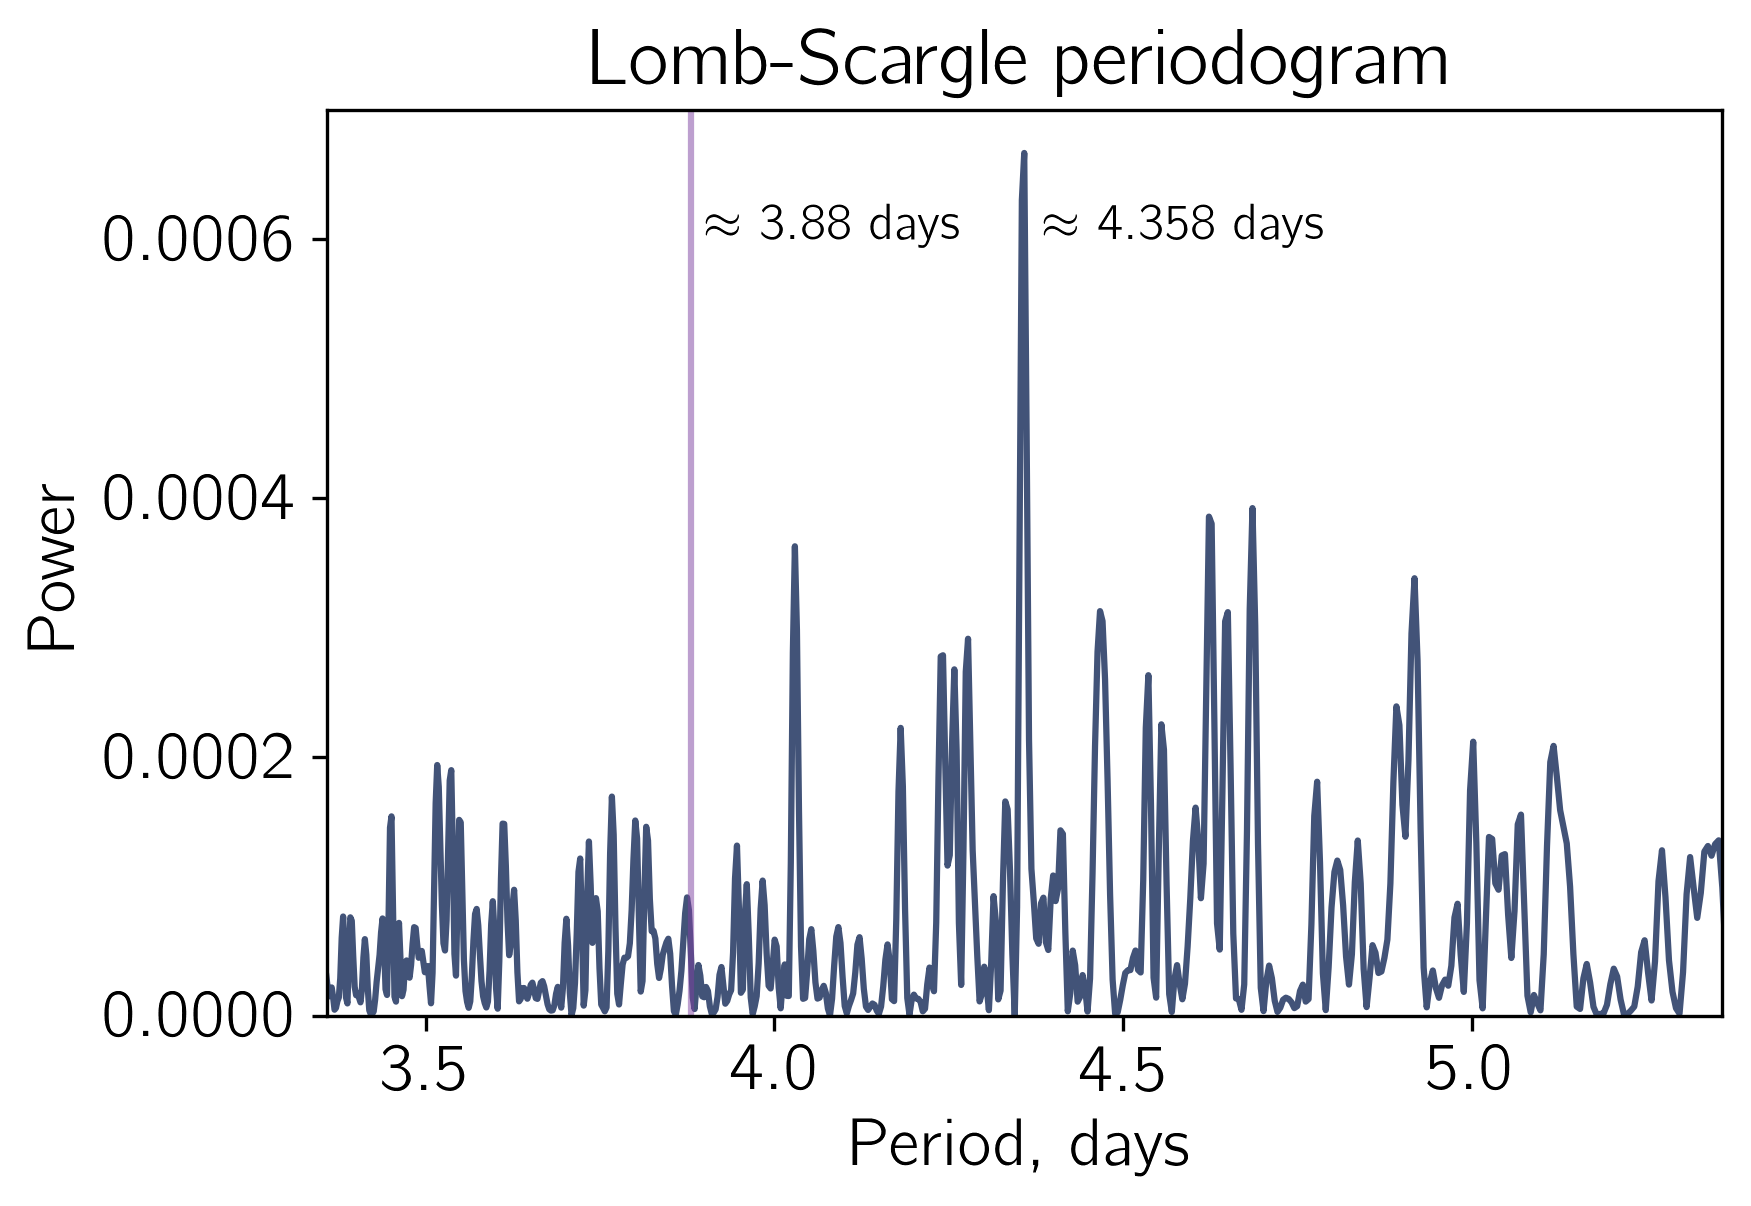

In [5]:
# Creating a set of evenly spaced frequencies
freq = np.linspace(1e-1, 1.0, 5000)

# Getting the PSD-normalized Lomb-Scargle power spectrum of the data using the fast method (O[N log N])
power = LombScargle(t, f).power(freq, method="fast", normalization="psd")

# Determining the maximum peak
period = 1.0 / freq[np.argmax(power)]

# Printing the x value of this peak
print("The maximum peak is at " + str(period))

# Scaling the output
power /= len(t)

# Plotting the result with emphasis on the period value
# and comparing it to the real value

# Plotting data
plt.plot(1.0 / freq, power, color="#425378")

# Marking the true period value
plt.axvline(3.88, color="#7C40A0", alpha=0.5)

# Adding approximate period values on the plot
plt.text(3.9, 0.0006, r"$\approx$ 3.88 days", fontsize=12)
plt.text(4.385, 0.0006, r"$\approx$ 4.358 days", fontsize=12)

# Setting limits
plt.xlim(period - 1, period + 1)
plt.ylim(0, 0.0007)

# Setting labels
plt.xlabel("Period, days")
plt.ylabel("Power")

# Setting title
plt.title("Lomb-Scargle periodogram")

# Saving the figure
plt.savefig("Figures/LS_periodogram", bbox_inches="tight")

# Showing the result
plt.show()

# Closing the plot
plt.close()

Taking a subset of the data (here: quarters [4](https://archive.stsci.edu/kepler/preview.php?type=lc&dsn=KPLR001430163-2010078095331) and [5](https://archive.stsci.edu/kepler/preview.php?type=lc&dsn=KPLR001430163-2010174085026) of the long cadence data):

In [6]:
# Defining a mask with time bounds
mask = (t >= 352.396596505) & (t <= 537.5502295)

# Taking the subset
t = t[mask]
f = f[mask]
ferr = ferr[mask]

print(t.size)

6950


Defining the covariance function as described in the example from Foreman-Mackey ([2017](https://www.mendeley.com/catalogue/fast-scalable-gaussian-process-modeling-applications-astronomical-time-series/)):

replicating the properties of

$ \LARGE k(\tau) = A \exp\left( - \frac{\tau^2}{2 l^2} - \Gamma \sin^2\left( \frac{\pi \tau}{P_{rot}} \right) \right)$

by constructing a simple <i>celerite</i> covariance function

$ \LARGE k(\tau) = \frac{a}{2 \ + \ b} e^{-\tau/c} \left[ \cos\left( \frac{2 \pi \tau}{P} \right) + (1 + b) \right] $

The parameters are defined by logarithms in the code for the simplicity of specifying priors. 

In [7]:
# Defining the custom kernel
class RotationTerm(terms.Term):
    """

    A subclass describing the celerite covariance function
    used in the Example 3 in Foreman-Mackey (2017)

    """

    # Defining the parameter names
    parameter_names = ("log_amp", "log_timescale", "log_period", "factor")

    # Overloading the function for getting real coefficients
    def get_real_coefficients(self, params):
        """

        An overloading method for ``get_real_coefficients``

        Parameters:
            params: An array containing values of the parameters

        Returns:
            A list of real coefficients

        """

        # Getting the values of the parameters
        log_amp, log_timescale, log_period, factor = params

        return (
            np.exp(log_amp) * (1.0 + factor) / (2.0 + factor),
            np.exp(-log_timescale),
        )

    # Overloading the function for getting complex coefficients
    def get_complex_coefficients(self, params):
        """

        An overloading method for ``get_complex_coefficients``

        Parameters:
            params: An array containing values of the parameters

        Returns:
            A list of complex coefficients

        """

        # Getting the values of the parameters
        log_amp, log_timescale, log_period, factor = params

        return (
            np.exp(log_amp) / (2.0 + factor),
            0.0,
            np.exp(-log_timescale),
            2 * np.pi * np.exp(-log_period),
        )

Specifying the values and the priors of the parameters according to the [example](https://github.com/dfm/celerite/blob/master/paper/figures/rotation/rotation.ipynb) <br>and to the Table 3 from Foreman-Mackey ([2017](https://www.mendeley.com/catalogue/fast-scalable-gaussian-process-modeling-applications-astronomical-time-series/)) respectively:

In [8]:
# Defining the priors
bounds = dict(log_amp=(-10.0, 0.0), log_timescale=(0.0, 2.5),
              log_period=(-3.0, 5.0), factor=(-1.0, 0.0))

# Building a kernel
kernel = RotationTerm(
    log_amp=np.log(np.var(f)),
    log_timescale=np.log(10.0),
    log_period=np.log(period),
    factor=-0.9,
    bounds=bounds
)

Building a <i>celerite</i> model with the specified kernel; defining the functions 
for computing negative marginalized log likelihood and the gradient of it:

In [9]:
# Building a celerite model with the specified kernel
gp = celerite.GP(kernel, mean=np.median(f))


def neg_log_like(params, y, model, m):
    """
    
    A function to get the negative marginalized log likelihood

    Parameters:
        params: An array containing parameter values;
        y : An array of data;
        model : A celerite model;
        m : A mask for an array of data

    Returns:
        The negative marginalized log likelihood
        
    """

    # Setting parameter values to the given vector
    model.set_parameter_vector(params)

    # Computing and returning the result
    return -model.log_likelihood(y[m])


def grad_neg_log_like(params, y, model, m):
    """
    
    A function to get the gradient of
    the negative marginalized likelihood 

    Parameters:
        params: An array containing parameter values;
        y : An array of data;
        model : A celerite model;
        m : A mask for an array of data

    Returns:
        The gradient of the negative
        marginalized likelihood
        
    """

    # Setting parameter values to the given vector
    model.set_parameter_vector(params)

    # Computing and returning the result
    return -model.grad_log_likelihood(y[m])[1]

Step-by-step $\Large\sigma$-clipping:

In [10]:
# Getting the values of the initial parameters
init_params = gp.get_parameter_vector()

# Getting the names of the parameters
params_names = [re.sub(r".*:", "", name) for name in gp.get_parameter_names()]

# Getting bounds values
bounds_values = gp.get_parameter_bounds()

# Creating an initial mask
sigma_mask = np.ones(len(t), dtype=bool)

# Main loop
while True:

    # Computing the extended form of the covariance matrix and factorizing
    gp.compute(t[sigma_mask], ferr[sigma_mask])

    # Minimizing the negative marginalized likelihood using the L-BFGS-B method
    opt = minimize(neg_log_like, init_params, jac=grad_neg_log_like,
                   method="L-BFGS-B", bounds=bounds_values, args=(f, gp, sigma_mask))

    # Setting the new parameters
    gp.set_parameter_vector(opt.x)

    # Computing the conditional predictive distribution of the model
    mu, var = gp.predict(f[sigma_mask], t, return_var=True)

    # Calculating standard deviation
    sig = np.sqrt(var + ferr ** 2)

    # Calculating the residuals
    rds = f - mu

    # Calculating a new mask
    new_sigma_mask = np.abs(rds) < 3 * sig

    # Comparing the masks
    if np.all(new_sigma_mask == sigma_mask):
        break

    # Updating the mask
    sigma_mask[:] = new_sigma_mask
    
# Saving the arrays using the computed mask
fit_t, fit_f, fit_ferr = t[sigma_mask], f[sigma_mask], ferr[sigma_mask]

# Copying ``gp``
ml_gp = copy.deepcopy(gp)

# Computing the extended form of the covariance matrix and factorizing
ml_gp.compute(fit_t, fit_ferr)

# Computing the marginalized log likelihood
ml_gp.log_likelihood(fit_f)

# Printing the optimal parameters

print("The maximum a posteriori parameters (MAP) inferred by\n",
      "minimizing the negative marginalized likelihood: \n", sep="")

for i in range(len(params_names)):
    print(params_names[i] + ":", opt.x[i])
    
print("\n", "Marginalized likelihood of the model: ", gp.log_likelihood(fit_f), sep="")

The maximum a posteriori parameters (MAP) inferred by
minimizing the negative marginalized likelihood: 

log_amp: -2.73439009227886
log_timescale: 0.8921929187481
log_period: 1.351101857759426
factor: -1.0

Marginalized likelihood of the model: 11569.731327537733


Printing found periods:

In [11]:
# Calculating the exponent of the inferred log-period
inf_period = np.exp(opt.x[-2])

# Printing the result and comparing to the initial value

print("The initial value of the period inferred studying Lomb-Scargle periodogram: " + str(period))
print("The value of the period inferred minimizing the negative marginalized likelihood: " + str(inf_period))

The initial value of the period inferred studying Lomb-Scargle periodogram: 4.358326068003487
The value of the period inferred minimizing the negative marginalized likelihood: 3.8616782074415545


Plotting the MAP model over initial data set:

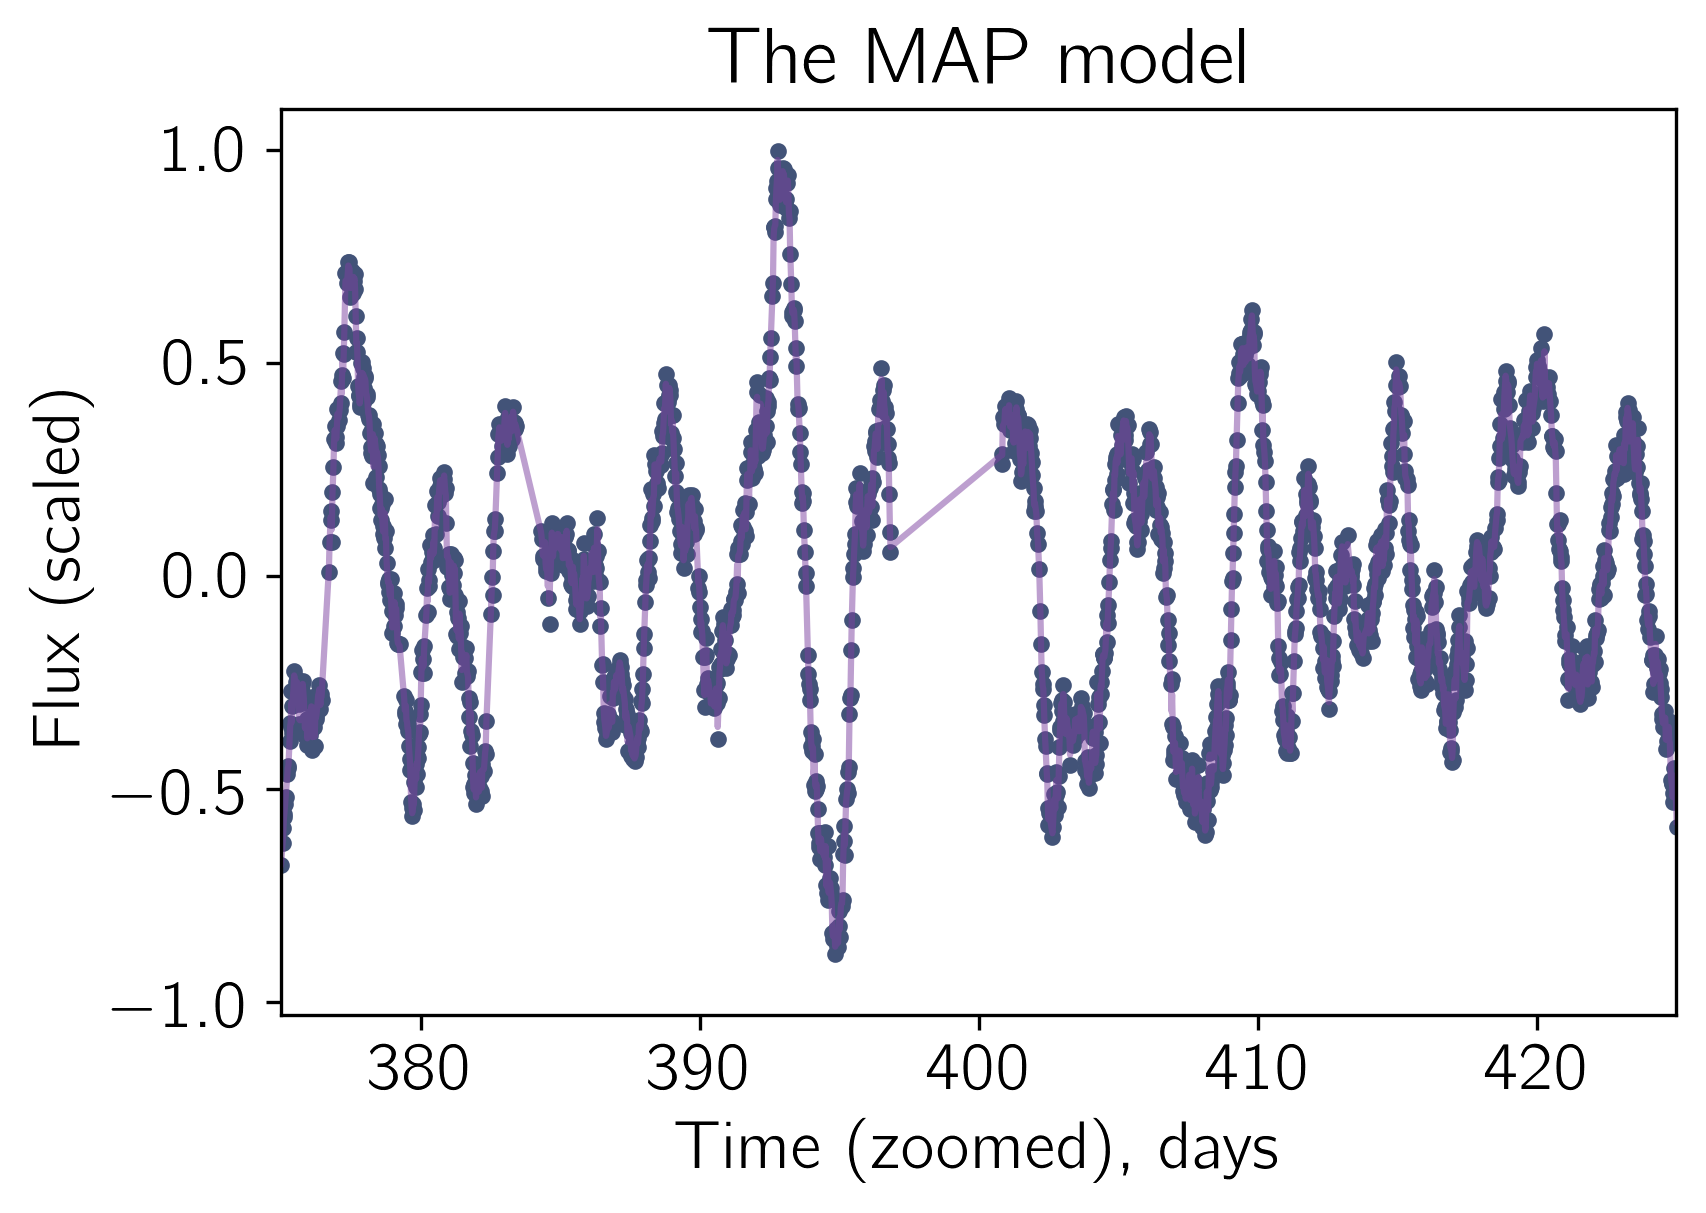

In [12]:
# Plotting the initial data set
plt.plot(t, f, ".", color="#425378")

# Plotting the MAP model
plt.plot(t, mu, color="#7C40A0", alpha = 0.5)

# Setting limits
plt.xlim(375, 425)

# Setting title
plt.title("The MAP model")

# Setting labels
plt.xlabel("Time (zoomed), days")
plt.ylabel("Flux (scaled)")

# Saving the figure
plt.savefig("Figures/MAP_model", bbox_inches="tight")

# Showing the plot in a cell
plt.show()

# Closing the plot
plt.close()

Plotting the residuals between the mean predictive model and the initial data:

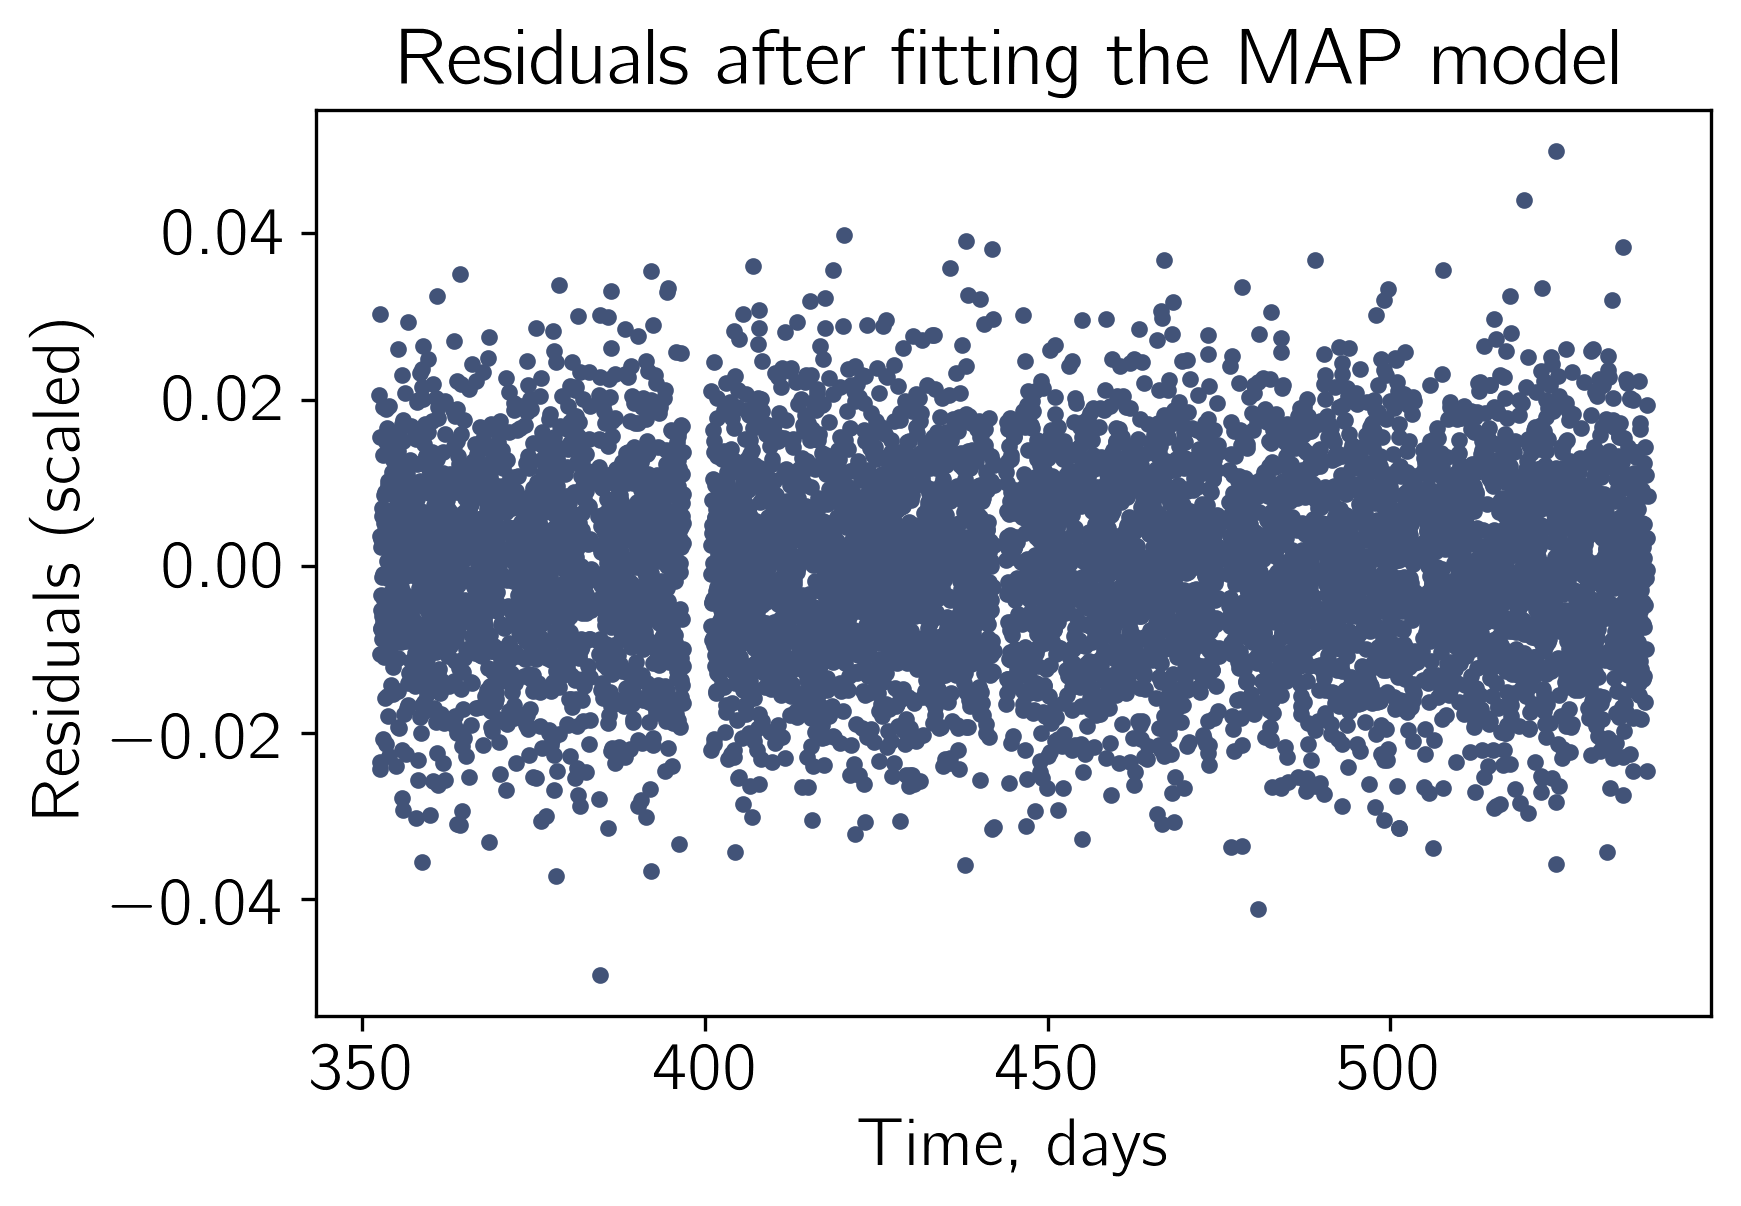

In [13]:
# Plotting the residuals
plt.plot(fit_t, rds[sigma_mask], ".", color="#425378")

# Setting title
plt.title("Residuals after fitting the MAP model")

# Setting labels
plt.xlabel("Time, days")
plt.ylabel("Residuals (scaled)")

# Saving the figure
plt.savefig("Figures/MAP_residuals", bbox_inches="tight")

# Showing the plot in a cell
plt.show()

# Closing the plot
plt.close()

Sampling using the Affine Invariant Markov chain Monte Carlo (MCMC) Ensemble sampler:

In [14]:
def log_prob(params):
    """

    A function to get the marginalized log likelihood plus
    the log prior probability of the current parameters

    Parameters:
        params: An array containing parameter values

    Returns:
        Sum of the marginalized log likelihood plus
        the log prior probability of the current parameters

    """

    # Setting parameter values to the given vector
    gp.set_parameter_vector(params)

    # Computing the log prior probability of the current parameters
    lp = gp.log_prior()

    # Computing the sum

    if not np.isfinite(lp):
        return -np.inf
    return lp + gp.log_likelihood(fit_f)


# Getting the number of parameters
ndim = len(opt.x)

# Setting the number of walkers
nwalkers = 32

# Setting the number of the burn-in steps
nburn = 500

# Setting the number of the MCMC steps
nsteps = 5000

# Deviating the MAP parameters with an isotropic
# Gaussian with a standard deviation of 10^{-5}
pos = opt.x + 1e-5 * np.random.randn(nwalkers, ndim)

# Computing the ``log_prob`` function for these parameters
lp = np.array(list(map(log_prob, pos)))

# Computing the map of infinite numbers
m = ~np.isfinite(lp)

# Excluding the infinte numbers by
# repeatedly deviating the parameters
while np.any(m):
    pos[m] = opt.x + 1e-5 * np.random.randn(m.sum(), ndim)
    lp[m] = np.array(list(map(log_prob, pos[m])))
    m = ~np.isfinite(lp)

# Opening a pool and setting the number of threads
pool = ip.InterruptiblePool(4)

# Creating an instance of the emcee sampler
sampler = emcee.EnsembleSampler(nwalkers, ndim, log_prob, pool=pool)

# Running burn-in
pos, _, _ = sampler.run_mcmc(pos, nburn, progress=True)

# Resetting the sampler
sampler.reset()

# Running production
sampler.run_mcmc(pos, nsteps, progress=True)

# Closing the pool
pool.close()

100%|██████████| 5000/5000 [01:21<00:00, 61.01it/s]


Visualizing multidimensional samples using a scatterplot matrix:

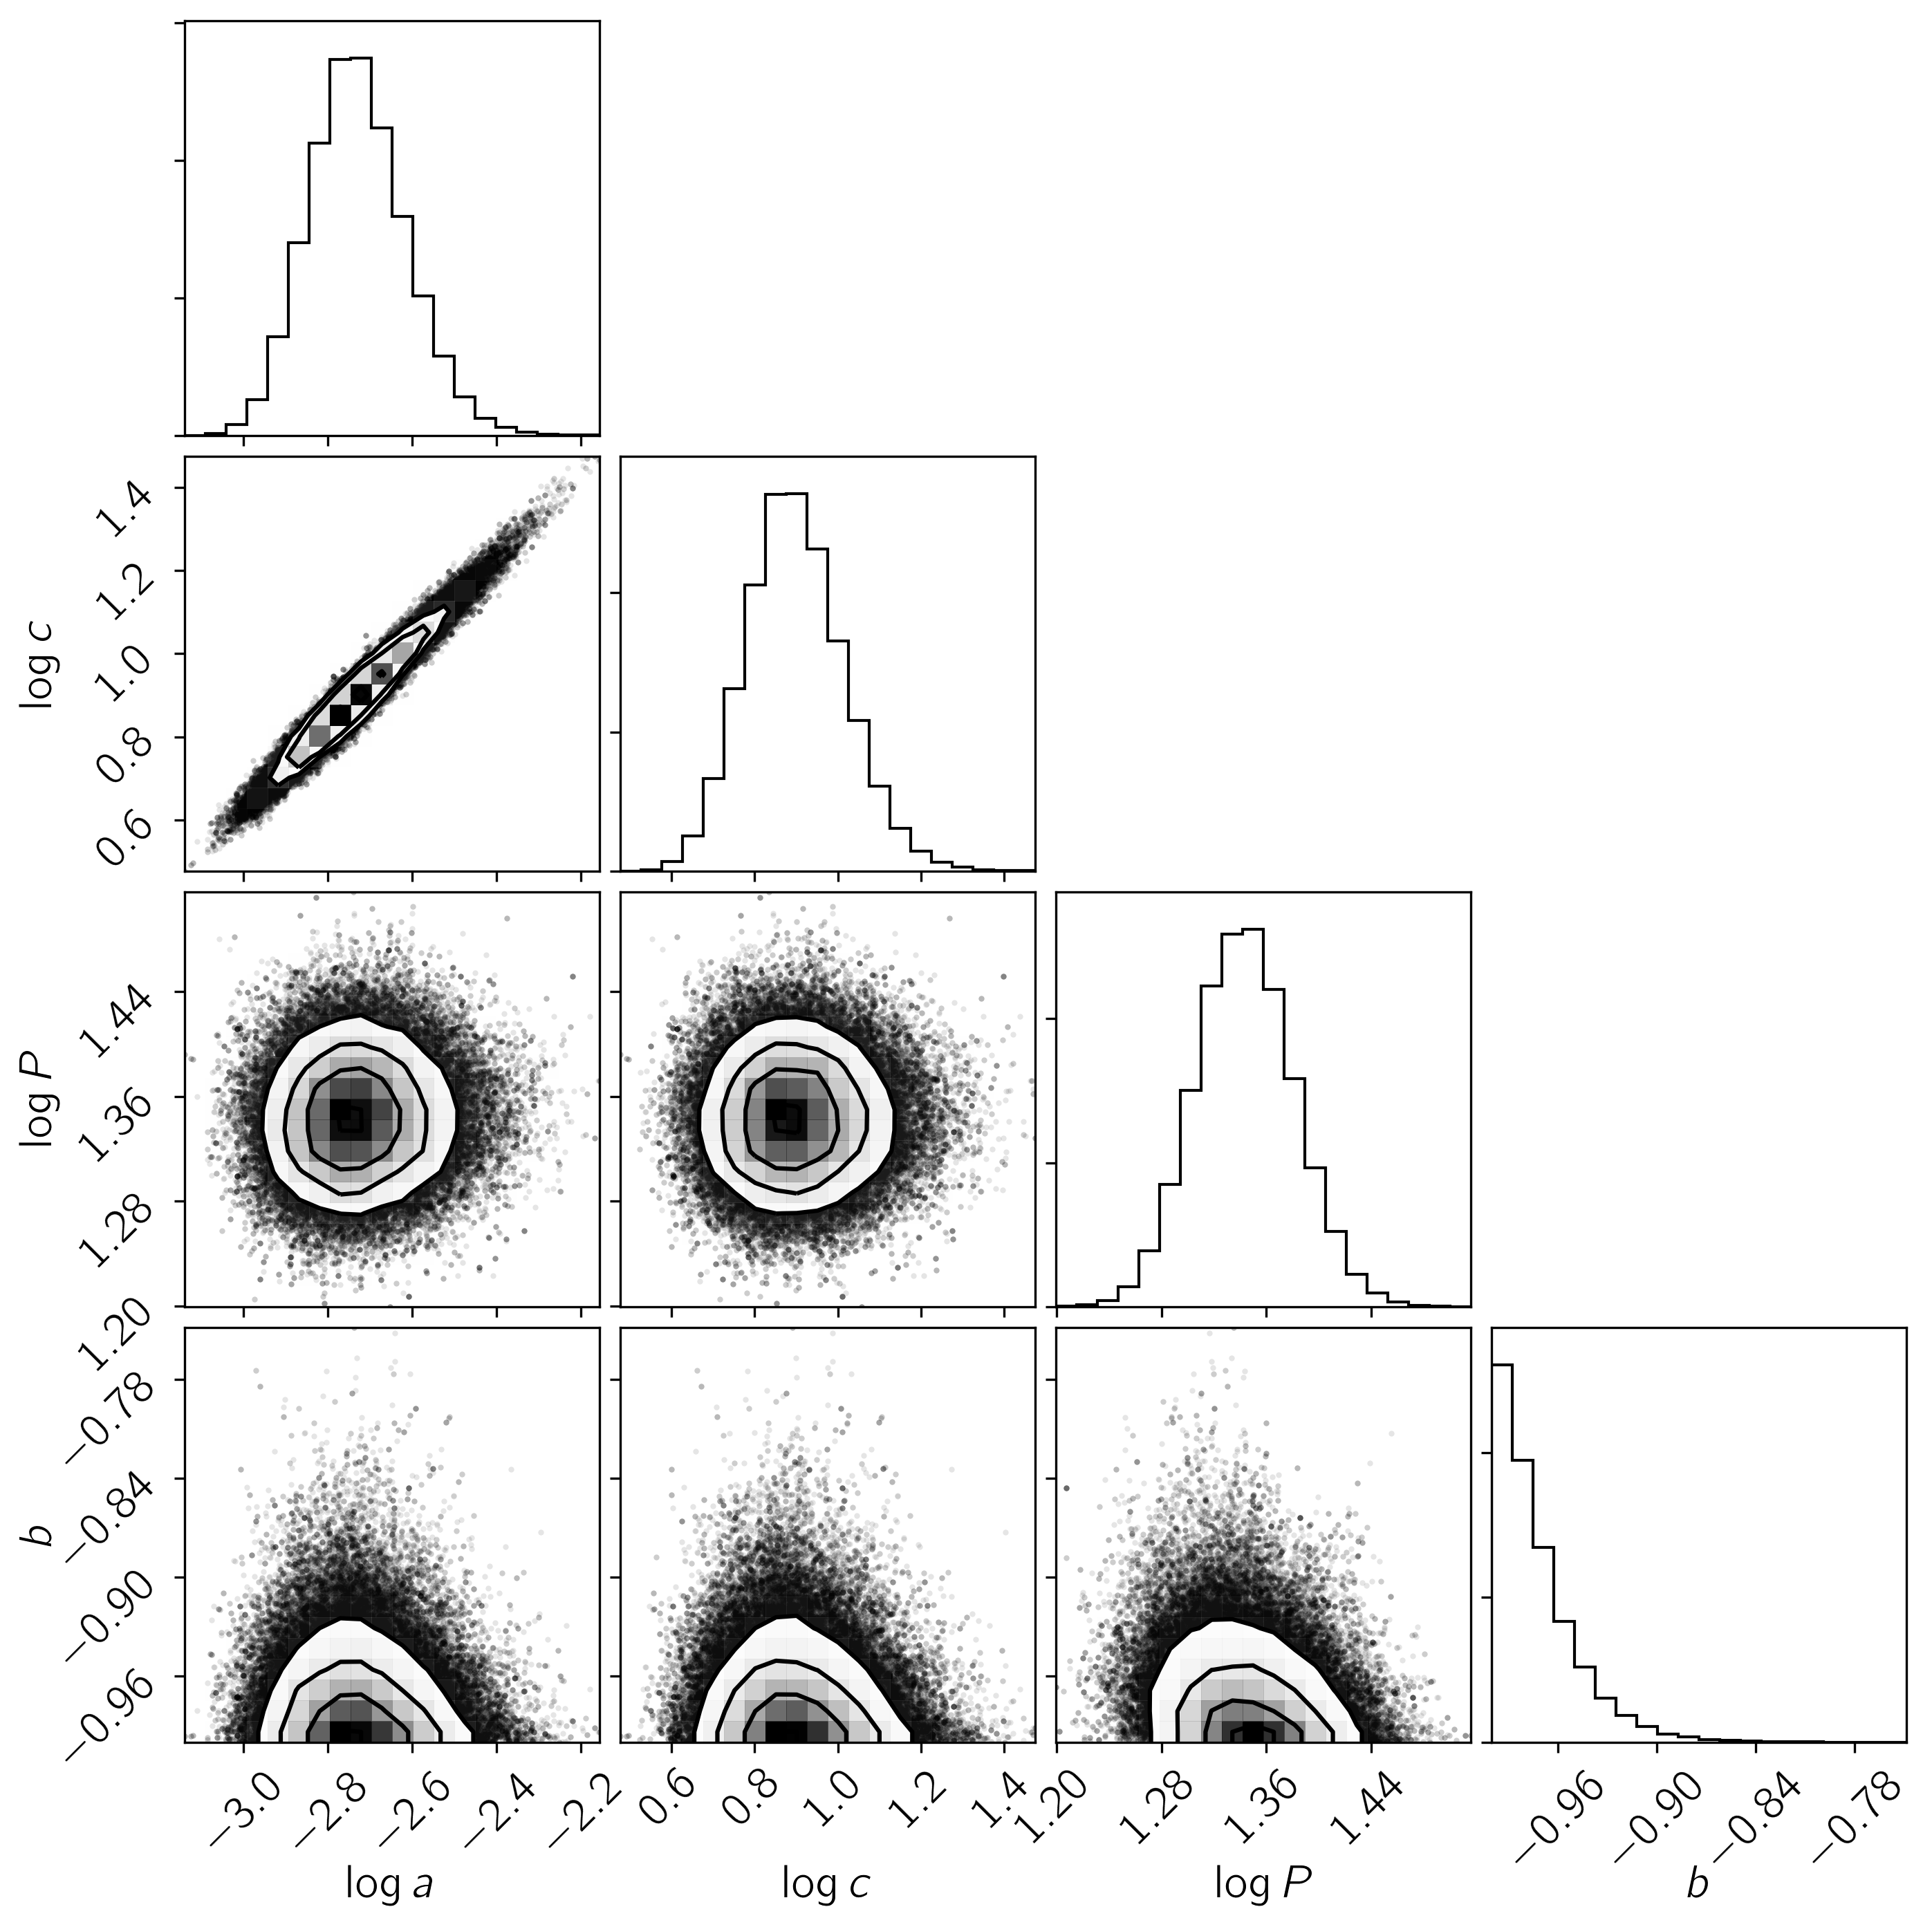

In [15]:
# Getting a chain
# chain = np.concatenate(
#     (sampler.flatchain.T, [sampler.flatlnprobability]), axis=0).T

# Plotting a corner plot of the chain
corner.corner(sampler.flatchain, labels=[r"$\log{a}$", r"$\log{c}$", r"$\log{P}$", r"$b$"])

# Saving the figure
plt.savefig("Figures/MCMC_corner_plot", bbox_inches="tight")

# Showing the plot in a cell
plt.show()

# Closing the plot
plt.close()